In [ ]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl 
import pyagrum.causal.notebook as cslnb
from typing import Generator
from random import random

In [83]:
def IDToBN(id: gum.InfluenceDiagram) -> gum.BayesNet:
    '''
    Description: 
    Converts an influence diagram to a bayesian diagram with the same structure.

    Arguments:
    influenceDiagram : gum.InfluenceDiagram

    Returns: 
    res : gum.BayesNet
    '''
    v = len(id.nodes()) # number of vertices in the graph
    res = gum.BayesNet()
    for i in range(v):  # copy nodes over
        res.add(gum.LabelizedVariable(str(i)))
    for src, dst in id.arcs():  # copy arcs over
        res.addArc(str(src), str(dst))
    return res

def getChanceNodes(id: gum.InfluenceDiagram) -> Generator[int, None, None]:
    ''' 
    Get all chance nodes in IDs.

    Yields the chance nodes in id.
    '''
    for node in id.nodes():
        if id.isChanceNode(node):
            yield node

def getDecisionNodes(id: gum.InfluenceDiagram) -> Generator[int, None, None]:
    ''' 
    Get all decision nodes in IDs.

    Yields the decision nodes in id.
    '''
    for node in id.nodes():
        if id.isDecisionNode(node):
            yield node

def getUtilityNodes(id: gum.InfluenceDiagram) -> Generator[int, None, None]:
    ''' 
    Get all utility nodes in IDs.

    Yields the utility nodes in id.
    '''
    for node in id.nodes():
        if id.isUtilityNode(node):
            yield node

def getRelU(id, decisionSet : set[int]) -> Generator[int, None, None]:
    '''
    Description:
    Get generator of relevant utility nodes to decisionSet in the ID

    Arguments:
    id : gum.InfluenceDiagram
    decisionSet : set[int]

    Returns a generator with all utility nodes that are descendants of nodes in decisionSet
    '''
    for u in set().union(*[id.descendants(i) for i in decisionSet]):
        if id.isUtilityNode(u):
            yield u

def backdoorBetweenSets(bn: gum.BayesNet, causeSet: set[int], effectSet: set[int], notBD: set[int]=set()) -> set[int]:
    ''' 
    Description:
    Get all backdoor sets between two sets of nodes

    Arguments:
    bn : gum.BayesNet
    causeSet : set[int]
    effectSet : set[int]
    notBD : set[int]

    Returns BD(causeSet, effectSet) excluding nodes in notBD
    '''
    if notBD is None:
        notBD = set()
    
    all_backdoors = set()
    
    for cause in causeSet:  #loop through causeSet x effectSet
        for effect in effectSet:
            backdoors = csl.backdoor_generator(bn, cause, effect, notBD)
            if backdoors:   # just the non empty bds
                for b in backdoors:
                    for nid in b:
                        all_backdoors.add(nid)
    return all_backdoors - causeSet - effectSet

def blocksAllBackDoorPaths(bn: gum.BayesNet, causeSet: set[int], effectSet: set[int], bd: set[int]) -> bool:
    ''' 
    Returns bool: True if bd blocks all backdoor paths if observed, False otherwise.
    '''
    aux = gum.BayesNet(bn)  # make temporary copy of bn
    for b in bd:
        aux.erase(b)        # delete all given BD nodes
    return backdoorBetweenSets(aux, causeSet, effectSet) == set()   # check if any paths are left

def getRelO(id: gum.InfluenceDiagram, decisionSet: set[int], relu: set[int] = None) -> set[int]:
    ''' 
    Returns set[int] set of relevant observed nodes (RELo) for decisionSet.
    '''
    if relu is None:
        relu = set(getRelU(id, decisionSet))
    bayesNet = IDToBN(id)
    parents = set().union(*[id.parents(d) for d in decisionSet])
    backDoor = backdoorBetweenSets(bayesNet, decisionSet, relu) & parents
    init = list(backDoor)   # start with pa(D')
    for b in init:
        if blocksAllBackDoorPaths(bayesNet, decisionSet, relu, backDoor - {b}): 
            # iteratively try to remove nodes until we reach the minimal RELo set
            backDoor.remove(b)
    return backDoor

def getRelH(id: gum.InfluenceDiagram, decisionSet: set[int], relU: set[int] = None) -> set[int]:
    ''' 
    Returns set[int] set of relevant hidden nodes (RELh) for decisionSet.
    '''
    bayesNet = IDToBN(id)
    obs = set().union(*[id.parents(d) for d in decisionSet])
    if relU is None:
        relU = set(getRelU(id, decisionSet))
    candidates = set().union(*[id.ancestors(u) for u in relU]) - obs - decisionSet
    relH = set()
    for c in candidates:
        if not bayesNet.dag().dSeparation({c}, relU, obs):
            relH.add(c)
    return relH

In [84]:
# TESTS TESTS
# needs one more
# TESTS

figure2 = gum.InfluenceDiagram()
figure2.loadBIFXML('figure_2.bifxml')
#gnb.showInfluenceDiagram(figure2)
decisionNodes = list(getDecisionNodes(figure2))
for d in decisionNodes:
    print(getRelO(figure2, {d}))
print(getRelO(figure2, {7, 8})) # conforme a l'exemple donné par l'article 

{1}
{2}
{5}
{2, 5}


In [85]:
pigs = gum.InfluenceDiagram()
pigs.loadBIFXML('pigs_limid.bifxml')
#gnb.showInfluenceDiagram(pigs)

True

In [104]:
class ClusterNode:
    index = 0
    def __init__(self, id: gum.InfluenceDiagram, rel_d: set[int], rel_u: set[int] = set(), rel_o: set[int] = set(), rel_h: set[int] = set(), init_on_your_own: bool = True):
        self.id = id
        self.index = ClusterNode.index
        ClusterNode.index += 1
        self.rel_d = rel_d
        if init_on_your_own:
            if not rel_u:
                self.rel_u = set(getRelU(self.id, rel_d))
            if not rel_o:
                self.rel_o = getRelO(self.id, rel_d, self.rel_u)
            if not rel_h:
                self.rel_h = getRelH(self.id, rel_d, self.rel_u)
        else:
            self.rel_u = rel_u
            self.rel_o = rel_o
            self.rel_h = rel_h
        self.nodeSet = set().union(self.rel_d, self.rel_u, self.rel_o, self.rel_h)
        self.incomingMessages = []  # from children
        self.outgoingMessage = None  # to parent after computing self
        self.value = None  # V^C (from paper)
        self.relOOut = None
        self.relOIn = None
    
    def __hash__(self):
        return hash(self.index) # they're hashable because i SAID SO

    # NO TREE HERE DIFFERENT STRUCTURE

    def getRelOOut(self):
        if self.relOOut:
            return self.relOOut
        self.relOOut = set()
        for nid in self.rel_o:
            if self.id.isDecisionNode(nid):
                self.relOOut.add(nid)
            else:
                pa = self.id.parents(nid)
                if not pa:
                    self.relOOut.add(nid)
                elif not (self.rel_h & pa):
                    self.relOOut.add(nid)
        self.relOIn = self.rel_o - self.relOOut
        return self.relOOut
    
    def nodeCount(self):
        return len(self.nodeSet)

class SubmodelTree(gum.DiGraph):
    def __init__(self):
        self.submodel2sid = dict()
        super().__init__()

    def addSubmodel(self, s: ClusterNode) -> int:
        new_sid = self.addNode()
        self.submodel2sid[new_sid] = s

    def addEdgesFromMessages(self):
        pass

    def linkReloOut(self):
        for sid in self.nodes():
            submodel = self.sid2submodel[sid]
            

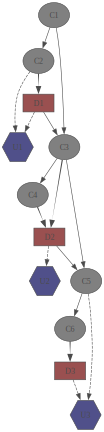

{8, 6, 7}
set()
{1, 2, 5}


In [105]:
gnb.showInfluenceDiagram(figure2)
decisions = set(getDecisionNodes(figure2))
print(decisions)
submodel = ClusterNode(figure2, decisions)
print(submodel.getRelOOut())
print(submodel.relOIn)

In [106]:
# MR LEE DECOMP

def layer_topo_sort_decisions(id: gum.InfluenceDiagram) -> Generator[set, None, None]:
    node2ch = {n: id.children(n) for n in id.nodes()}
    while True:
        leafs = {n for n, ch in node2ch.items() if not ch}
        if not leafs:
            break
        yield leafs

        for n in leafs:
            for m in id.parents(n):
                node2ch[m] -= leafs
        for n in leafs:
            del node2ch[n]

def filter_subsets(subsets, filter_set):
    for t in subsets:
        ss = filter_set & t
        if ss:
            yield ss

def decompose(id: gum.InfluenceDiagram) -> ClusterNode:
    st = SubmodelTree()
    decisions = set(getDecisionNodes(id))
    decisions_free = set(getDecisionNodes(id))
    blocks = list(filter_subsets(layer_topo_sort_decisions(id), decisionNodes))
    immediate_observed_nodes = {}
    informational_arcs = set()
    messages = set()
    for block in blocks:
        for _ in block:

            best_score, best_submodel = float('inf'), None
            for d in block:
                if d not in decisions_free:
                    continue
                unstable_decisions = {d} # SUBMODEL STARTING FROM D
                rel_d = set()

                temp_info_arcs = {}
                while unstable_decisions:
                    rel_d.update(unstable_decisions)
                    if len(rel_d) > 1:
                        rel_d_list = list(rel_d)
                        for i in range(len(rel_d)):
                            for j in range(i+1, len(rel_d)):
                                couples = [(rel_d_list[i], rel_d_list[j]), (rel_d_list[j], rel_d_list[i])]
                                for d1, d2 in couples:
                                    if d1 not in temp_info_arcs:
                                        temp_info_arcs[d1] = set() 
                                    temp_info_arcs[d1].update((el, d1) for el in immediate_observed_nodes[d2] if el not in decisions)
                                    for src, dst in temp_info_arcs[d1]:
                                        id.addArc(src, dst)
                    rel_u = getRelU(id, rel_d)  # DONT UPDATE
                    rel_o = getRelO(id, rel_d, rel_u)
                    rel_h = getRelH(id, rel_d)
                    unstable_decisions = (decisions_free - rel_d) & rel_h    # relevant decisions    # to be stabilised
                s = ClusterNode(id, rel_d, rel_u, rel_o, rel_h)
                if s.nodeCount < best_score:
                    best_score = s.nodeCount
                    best_submodel = s
                if len(rel_d) > 1:
                    for d1 in rel_d:
                        for src, dst in temp_info_arcs[d1]:
                            id.eraseArc(src, dst)
        if best_submodel is None:
            continue

        decisions_free -= best_submodel.rel_d

        if len(best_submodel.rel_d) > 1:
            added_edges = set()
            d = list(best_submodel.rel_d)
            for i in range(len(d)):
                for j in range(i+1, len(d)):
                    couples = [(d[i], d[j]), (d[j], d[i])]
                    for d1, d2 in couples:
                        immediate_observed_nodes[d1].update(immediate_observed_nodes[d2] - decisions)
                        added_edges.update((el, d1) for el in immediate_observed_nodes[d2] if el not in decisions)
            for src, dst in added_edges:
                id.addArc(src, dst)
            informational_arcs.update(added_edges)

            # relo out
            rel_o_out = set()
            rel_o_immediate = set()
            for d in best_submodel.rel_d:
                rel_o_immediate.update(immediate_observed_nodes[d] & best_submodel.rel_d)

            for nid in best_submodel.rel_o:
                if nid in decisions:
                    rel_o_out.add(nid)
                else:
                    pa = id.parents(nid)
                    if not pa:
                        if nid not in rel_o_immediate:
                            rel_o_out.add(nid)
                    else:
                        if not (best_submodel.rel_h & pa):
                            rel_o_out.add(nid)

            if rel_o_out:
                m = (best_submodel.index, None)
                messages.add(m)

                that_submodel = id.addUtilityNode(gum.LabelizedVariable('U_temp', f'i got added by the decomp', 1))
                for p in rel_o_out:
                    id.addArc(p, that_submodel)
            
            for u in best_submodel.rel_u:
                id.erase(u)
            for d in best_submodel.rel_d:
                id.erase(d)
            barren_nodes = (set(getChanceNodes(id)) - set().union(*[id.parents(d) for d in getDecisionNodes(id)])) - set().union(*[id.parents(u) for u in getUtilityNodes(id)]) # "This needs at least a line of comment"
            # no but actually it's the hidden nodes that relate to the submodel to be removed
            for b in barren_nodes:
                id.erase(b)
            # the erasure of the barren kind 
    
    for u in getUtilityNodes(id): 
        s = ClusterNode(id, {}, {u}, {}, id.ancestors(u))

    for sid in SubmodelTree.nodes():
        submodel = st.submodel2sid[sid]

    # messages dont have destination, approach interesting though
             

In [107]:
# BRUTE FORCE DECOMP

def set_partitions(s: set[any]) -> list[set[any]]:
    ''' 
    helper function to get all partitions of a set of nodes. 
    '''
    if not s:
        return [[]]
    
    s = list(s)

    def helper(s):
        if len(s) == 1:
            return [[[s[0]]]]

        first = s[0]
        rest_partitions = helper(s[1:])
        result = []

        for partition in rest_partitions:
            # insert first into each existing subset
            for i in range(len(partition)):
                new_partition = [subset.copy() for subset in partition]
                new_partition[i].append(first)
                result.append(new_partition)
            # or put first into a new subset
            result.append([[first]] + [subset.copy() for subset in partition])

        return result

    # convert inner lists to sets
    raw_partitions = helper(s)
    return [list(map(set, part)) for part in raw_partitions]

def is_stable(id, rel_d):
    decisions = set(getDecisionNodes(id))
    if set(getRelH(id, rel_d)) & decisions:
        return False
    return True

def all_stable(id, partition):
    return all(is_stable(id, p) for p in partition)

def partition_brute_force(id: gum.InfluenceDiagram):
    decisions = set(getDecisionNodes(id))
    partitions = set_partitions(decisions)
    possible_decomps = []
    for p in partitions:
        if all_stable(id, p):
            possible_decomps.append(p)
    lens = list(map(lambda x : len(x), possible_decomps))
    best_decomp = possible_decomps[lens.index(max(lens))]
    return best_decomp

def decompose(id: gum.InfluenceDiagram, partition: list[set[int]]) -> SubmodelTree:
    res = SubmodelTree()
    for p in partition:
        submodel = ClusterNode(id, p)
        res.addSubmodel(submodel)
        to_link = set()
        for nid in submodel.nodeSet:
            to_link.update(id.parents(nid) & (id.nodes() - submodel.nodeSet))
            id.erase(nid)
        new_utility = id.addUtilityNode(gum.LabelizedVariable('U_star', '', 1))
        for nid in to_link:
            id.addArc(nid, new_utility)
    return res

In [108]:
def randomID(n: int = 10, p: float = 0.2):
    basis = gum.randomBN(n=n)
    res = gum.InfluenceDiagram()
    for nid in basis.nodes():
        if basis.children(nid):
            if random() < p:
                res.addDecisionNode(gum.LabelizedVariable(str(nid), '', 2), nid)
            else:
                res.addChanceNode(gum.LabelizedVariable(str(nid), '', 2), nid)
        else:
            res.addUtilityNode(gum.LabelizedVariable(str(nid), '', 1), nid)
    for src, dst in basis.arcs():
        res.addArc(str(src), str(dst))
    return res

In [118]:
random_guy = randomID(25, 0.3)
print(partition_brute_force(random_guy))
random_guy

[{10}, {20}, {3, 5, 9, 19, 22}]


(pyagrum.InfluenceDiagram@000002DBB6770220) Influence Diagram{
  chance: 14,
  utility: 4,
  decision: 7,
  arcs: 30,
  domainSize: 10^6.32163
}

In [119]:
decompose(random_guy, [{10}])

(pyagrum.DiGraph@000002DBB5F84B20) {0} , {}

In [120]:
random_guy

(pyagrum.InfluenceDiagram@000002DBB6770220) Influence Diagram{
  chance: 10,
  utility: 4,
  decision: 6,
  arcs: 20,
  domainSize: 65536
}

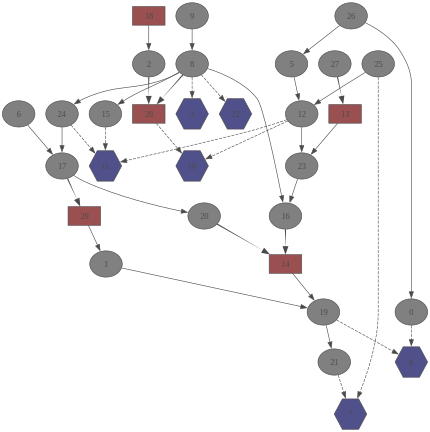

(non trivial) DECOMP FOUND!!: [{18, 28}, {13, 29, 14}]


In [37]:
state = []
while len(state) < 1:
    state = []
    random_guy = randomID(30, 0.3)
    for p in set_partitions(set(getDecisionNodes(random_guy))):
        if all_stable(random_guy, p) and len(p) > 1:
            state.append(p)
gnb.showInfluenceDiagram(random_guy)
for s in state:
    print('(non trivial) DECOMP FOUND!!:', s)

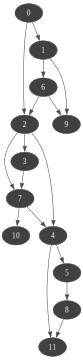

[{9, 10, 11}, {8}, {5}, {4}, {7}, {3}, {2}, {6}, {1}, {0}]

In [24]:
gnb.showBN(IDToBN(figure2))
list(layer_topo_sort_decisions(figure2))

In [30]:
model = pigs
for p in set_partitions(set(getDecisionNodes(model))):
        if all_stable(model, p):
            print(p)
pigs

[{8, 9, 7}]


(pyagrum.InfluenceDiagram@000002DBB650EB00) Influence Diagram{
  chance: 7,
  utility: 4,
  decision: 3,
  arcs: 16,
  domainSize: 1024
}